# 몬테카를로 베이지안 분석

## 표본 생성

확률변수의 분포함수 $p(X)$를 알고 있다고 하자. 이 분포함수를 따르는 표본을 생성하는 방법들에 대해 공부한다.

* 균일분포
* 역변환
* rejection sampling
* importance sampling

## 균일분포

파이썬의 난수 생성기(Radom Number Generator)는 마츠모토 마코토(松本 眞)와 니시무라 타쿠지(西村 拓士)가 고안한 메르센 트위스터(Mersenne Twister) 알고리즘 중에서 주기가 $2^{19937}-1$인 MT19937 알고리즘을 사용한다. 이 알고리즘에서 생성되는 값은 사실 정확한 난수가 아니라 $2^{19937}-1$ 주기로 반복되는 결정론적 수열이므로 유사 난수 생성기(Pseudo Radom Number Generator)이다. 이 값을 주기로 나누어 0부터 1사이의 부동소수점을 출력하는 균일분포(uniform distribution) 표본 생성에 사용한다.

## 역변환

확률분포함수가 수식으로 주어지는 기본적인 확률분포들의 경우에는 역변환(inverse transform) 방법을 사용하여 표본을 생성할 수 있다.

앞서 균일분포함수는 컴퓨터로 생성할 수 있다고 했다. 이 균일분포에서 생성된 $x$값을 임의의 실수로 변환하는 단조증가함수 $f(x)$를 생각해보자.
이 함수를 적용한 값을 $y$라고 하고 $y$를 표본으로 가지는 확률변수를 $Y$라고 하면 $Y$의 누적분포함수는 $f$의 역함수인 $f^{-1}$이 된다.

$$ F_Y(y) = f^{-1}(x) $$

<img src="https://datascienceschool.net/upfiles/9adf8abecbdf4bbd8968377075026950.png">

그림 51.1 : 역변환

반대로 생각하면 우리가 원하는 확률분포함수 $p(Y)$가 있다면 이 함수를 적분한 함수의 역함수를 균일분포 표본에 적용하면 우리가 원하는 확률분포를 가지게 된다.


$$ x = h(y) = \int_{-\infty}^{y} p(u)du $$

$$ y = h^{-1}(x) $$

## Rejection Sampling

우리가 원하는 분포함수가 수식으로 주어지고 적분 및 역함수를 구하기 쉽다면 역변환 방법을 쓸 수 있지만 그렇지 않은 경우에는 rejection sampling이라는  방법을 사용할 수 있다.

rejection sampling 방법에서는 목표 확률분포 $p(x)$와 유사하지만 표본 생성이 쉬운 유사 확률분포 $q(x)$를 사용한다.

* $p(x)$: 샘플링하고자 하는 목표 확률분포
* $q(x)$: 샘플링 가능한 유사 확률분포

방법은 간단하다. 일단 유사 확률분포 $q(x)$의 표본을 생성한 다음에 $p(z)/kq(z)$의 확률로 이 표본을 채택할지 아니면 버릴지를 결정한다. 
이 때 $k$는 $kq(x) \geq p(x)$가 되도록 하는 스케일링 상수이다. 


<img src="https://datascienceschool.net/upfiles/82be070d572241ebadda0eb9f7036484.png">

그림 51.2 : Rejection sampling

예를 들어 $a=2, b=6$인 베타 분포의 표본을 만들고 싶은데 지금 생성할 수 있는 확률분포는 정규분포밖에 없다고 하자. 그러면 일단 정규분포의 표본을 생성한다. 그리고 모수가 $p(z)/kq(z)$인 베르누이 확률분포의 표본값을 사용하여 표본을 버릴지 채택할 지 결정한다. 

다음 그림에서 왼쪽은 처음에 유사분포로 생성한 표본이고 오른쪽은 채택된 표본을 보이고 있다.

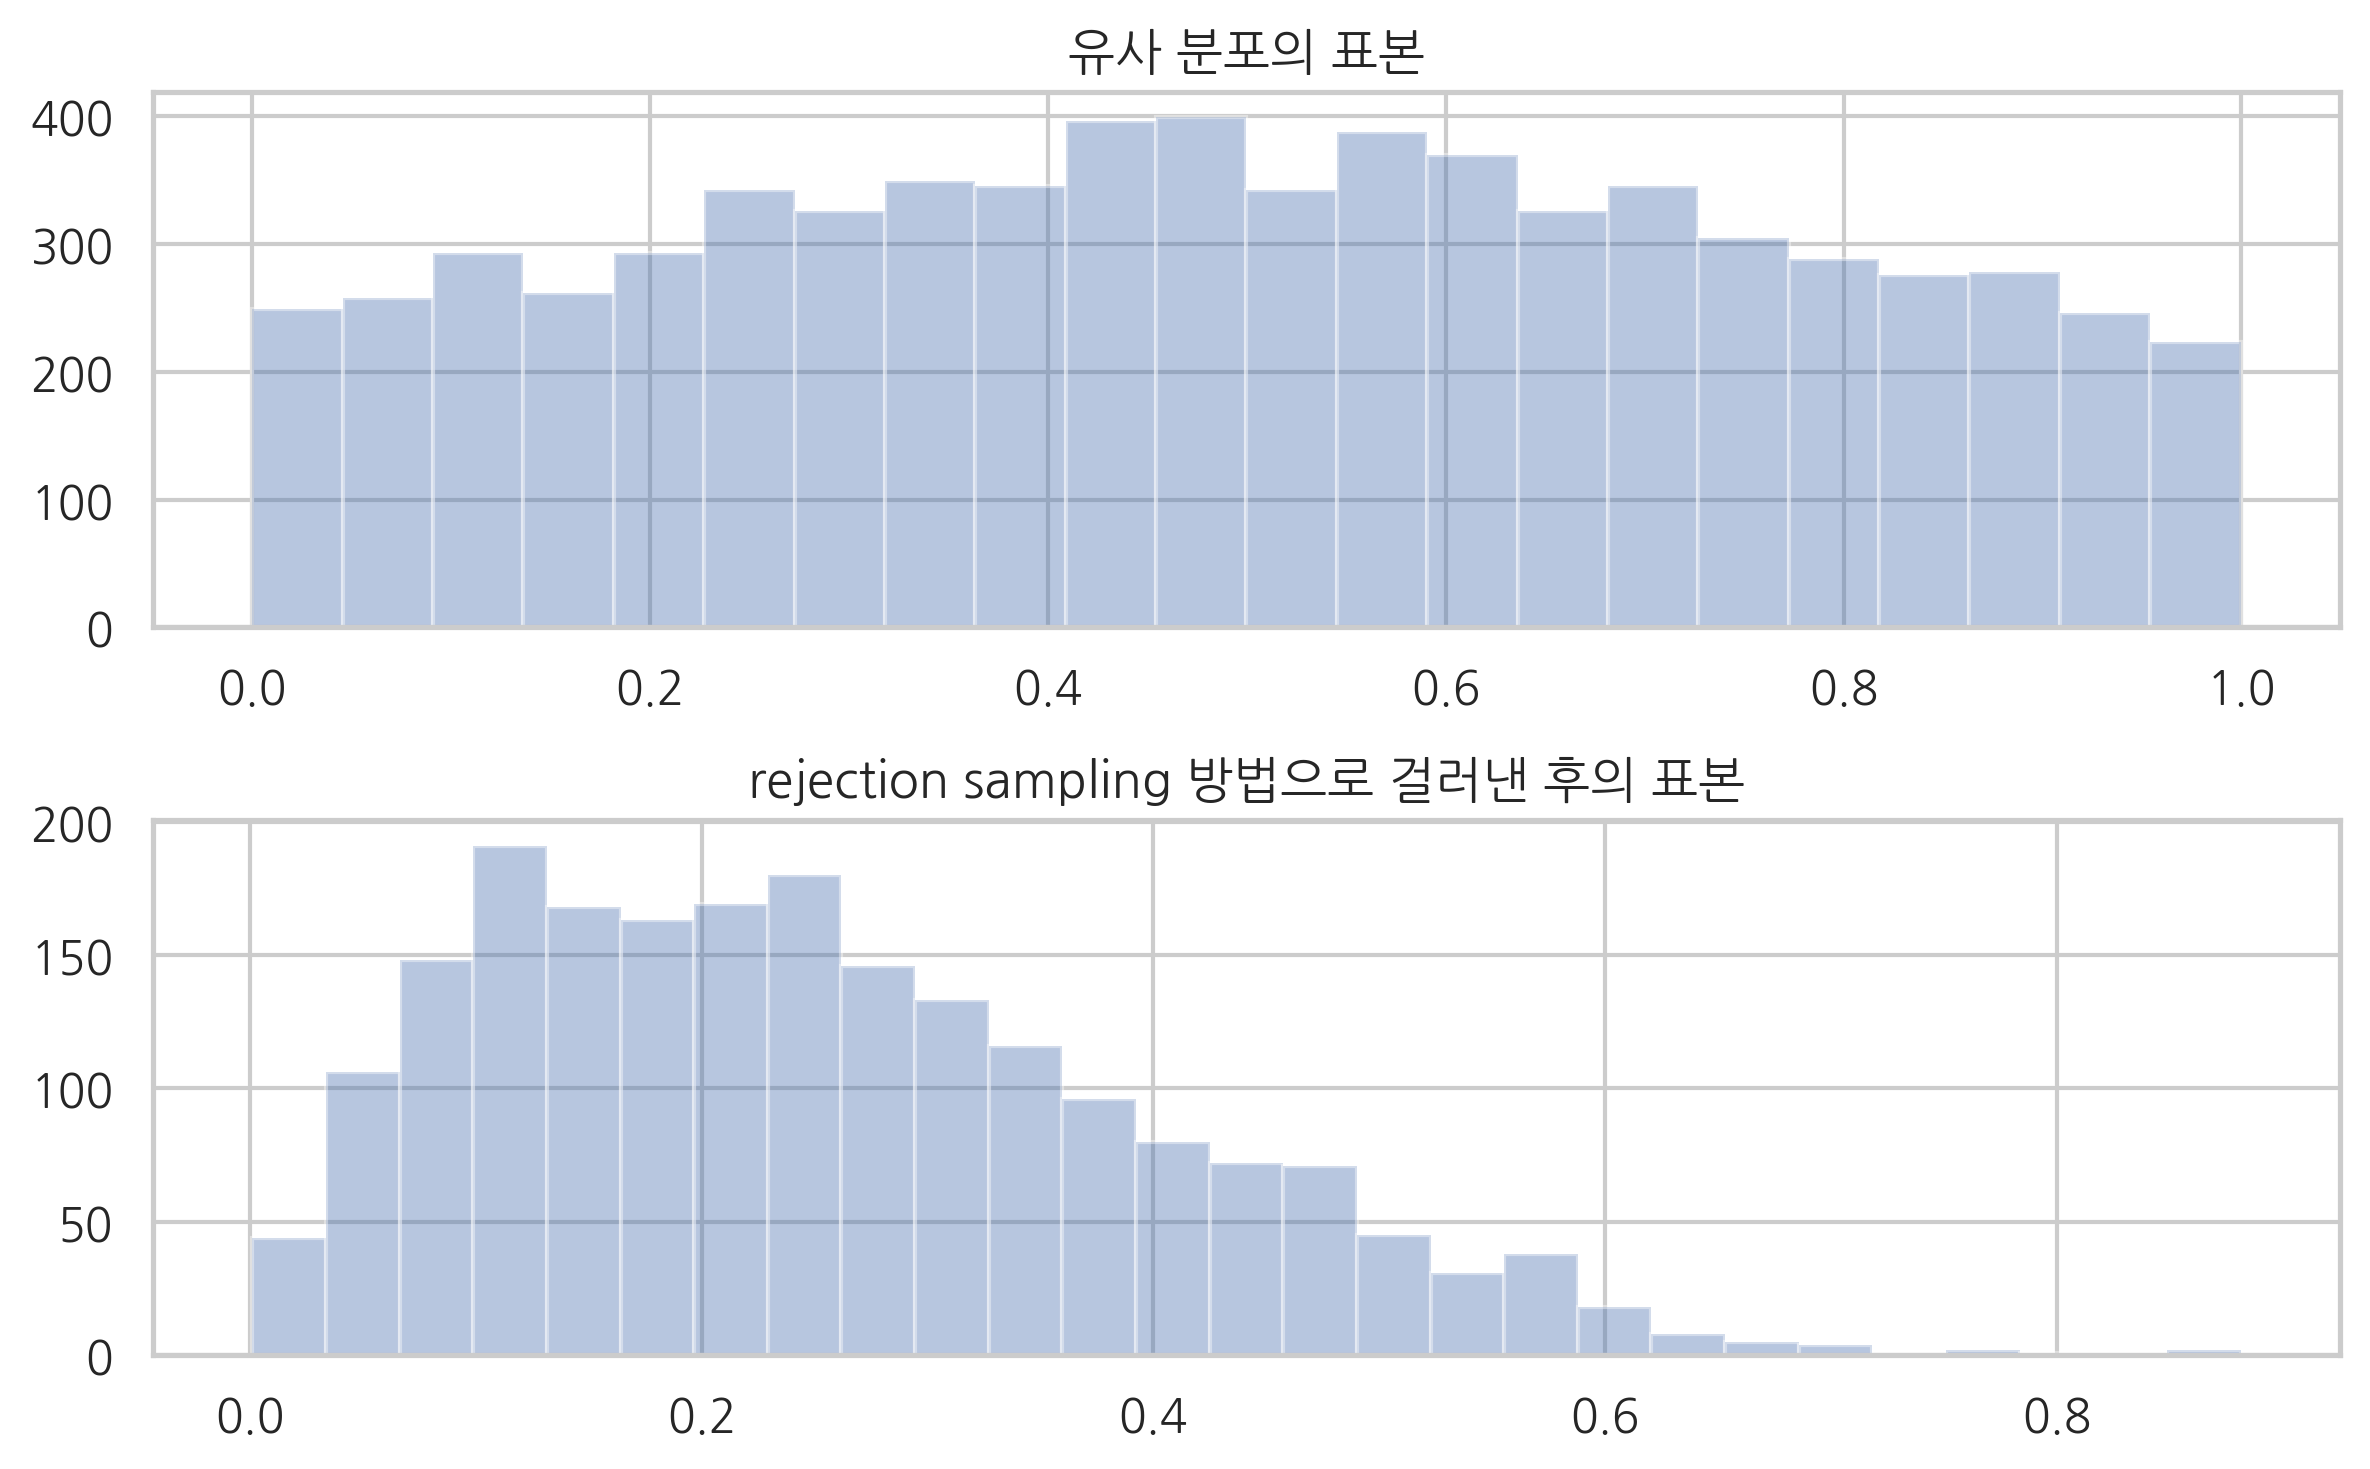

In [1]:
a = 2
b = 6
rv_p = sp.stats.beta(a, b)
rv_q = sp.stats.norm(loc=0.5, scale=0.5)
k = 5

np.random.seed(0)
x_q0 = rv_q.rvs(int(1e4))
x_q = x_q0[(x_q0 >= 0) & (x_q0 <= 1)]
crits = rv_p.pdf(x_q) / (rv_q.pdf(x_q) * k)
coins = np.random.rand(len(x_q))
x_p = x_q[coins < crits]

plt.subplot(211)
sns.distplot(x_q, kde=False)
plt.title("유사 분포의 표본")
plt.subplot(212)
sns.distplot(x_p, kde=False)
plt.title("rejection sampling 방법으로 걸러낸 후의 표본")
plt.tight_layout()
plt.show()

이해를 돕기 위해 실제로 유사 분포에 의해 만들어진 표본을 그리고 채택된 것은 크게, 버려진 건은 작게 표시하였다.

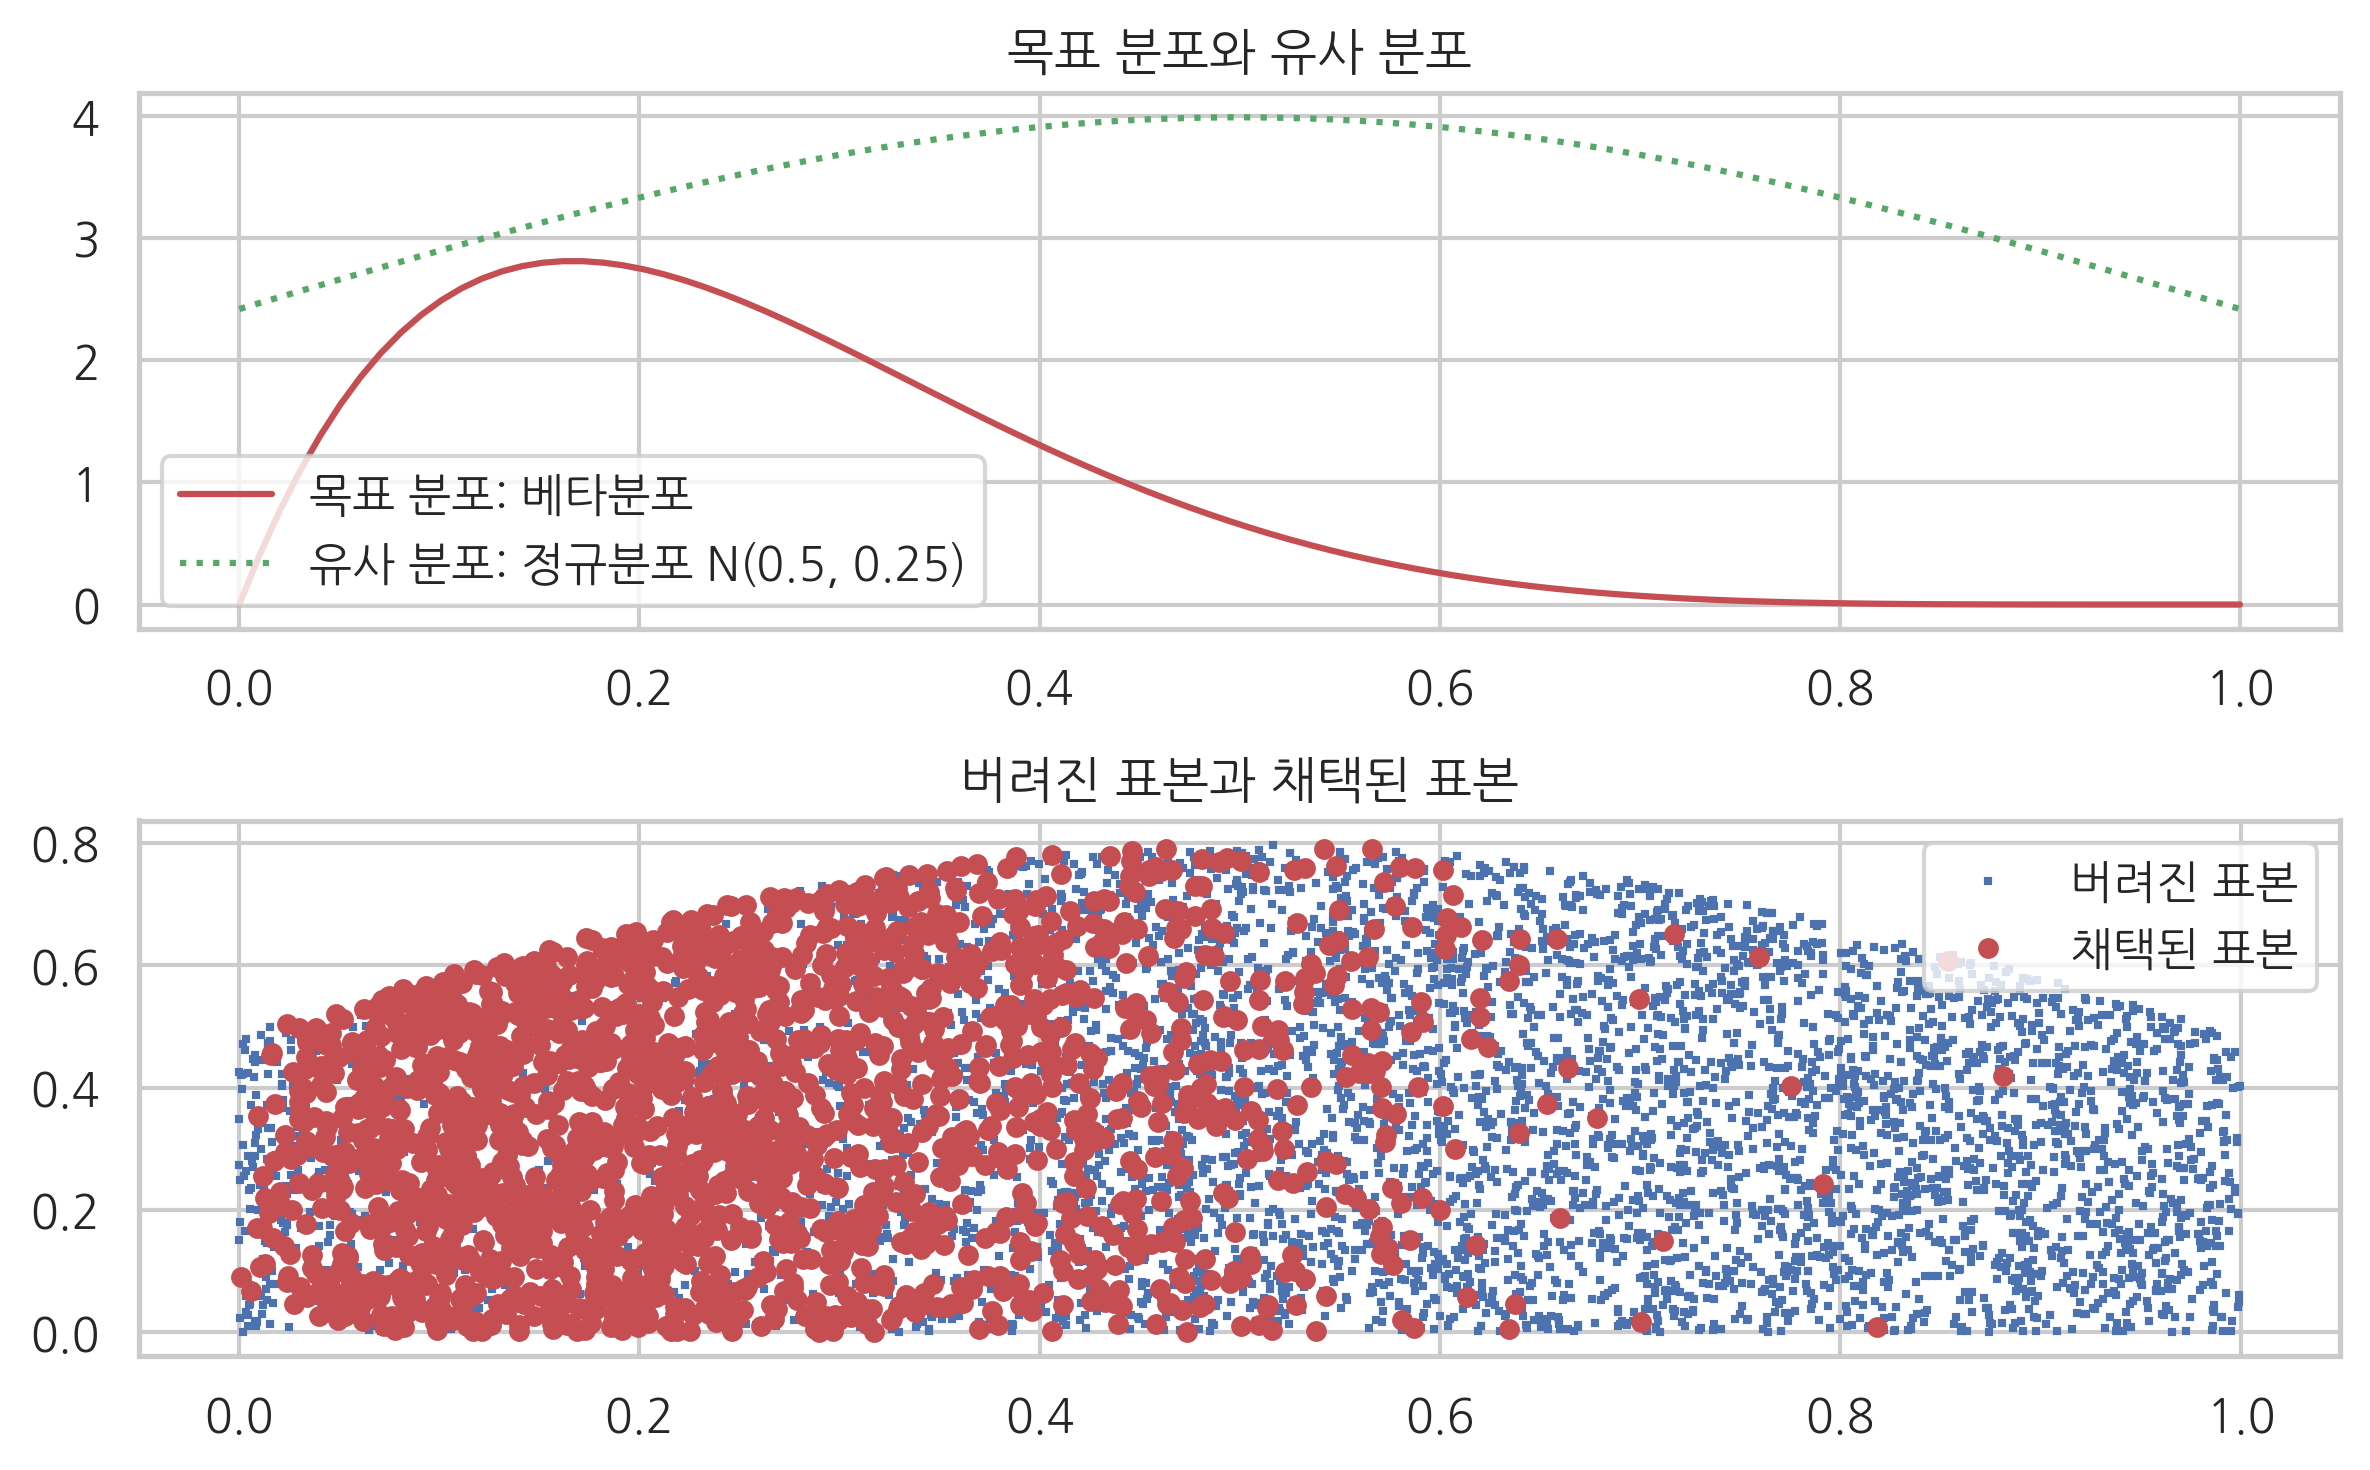

In [2]:
plt.subplot(211)
xx = np.linspace(0, 1, 100)
plt.plot(xx, rv_p.pdf(xx), 'r-', label="목표 분포: 베타분포")
plt.plot(xx, rv_q.pdf(xx) * k, 'g:', label="유사 분포: 정규분포 N(0.5, 0.25)")
plt.legend()
plt.title("목표 분포와 유사 분포")
plt.subplot(212)
y = np.random.rand(len(x_q)) * rv_q.pdf(x_q)
plt.plot(x_q, y, 'bs', ms=1, label="버려진 표본")
ids = coins < crits
plt.plot(x_q[ids], y[ids], 'ro', ms=4, label="채택된 표본")
plt.legend()
plt.title("버려진 표본과 채택된 표본")
plt.tight_layout()
plt.show()

## 기댓값 추정

확률분포의 표본을 생성하는 이유 중의 하나는 표본을 이용하여 그 확률분포의 기댓값을 추정할 수 있기 때문이다. 우리가 관심을 가지는 확률분포 $p(X)에 대해 기댓값

$$ \text{E}[f(X)] = \int f(x)p(x)dx $$

를 구하면 싶을 때, $N$개의 표본 데이터 $\{ x_1, \ldots, x_N \}$이 존재한다면 몬테카를로 적분

$$ \text{E}[f(X)] \approx \dfrac{1}{N} \sum_{i=1}^N f(x_i) $$

을 이용하여 기댓값을 추정할 수 있다. 물론 이 값은 오차가 존재하지만 표본의 갯수 $N$이 증가할수록 오차는 작아진다.

앞의 예제에서 $a=2, b=6$인 베타 분포의 기댓값은 

$$ \dfrac{a}{a + b} = \dfrac{1}{4} $$

이지만 표본 데이터를 몬테카를로 적분해도 유사한 값을 얻을 수 있다.

In [3]:
x_p.mean()

0.25452461685193456

## Importance Sampling

만약 기댓값을 계산하고자 하는 것이 표본을 생성하는 유일한 목적이라면 표본 생성과 기댓값 계산을 위한 몬테카를로 적분을 하나로 합친 importance sampling을 사용할 수 있다. rejection sampling에서와 같이 $kq > p$인 유사 분포 $q$의 표본을 생성하고 다음 식을 이용하여 직접 기댓값을 계산한다.

$$
\begin{eqnarray}
\text{E}[f(X)] 
&=& \int f(x)p(x)dx  \\
&=& \int f(x)\dfrac{p(x)}{q(x)} q(x) dx  \\
&\approx & \dfrac{1}{N} \sum_{i=1}^N f(x_i)\dfrac{p(x_i)}{q(x_i)}  \\
\end{eqnarray}
$$

이 식에서 $\dfrac{p(x_i)}{q(x_i)}$은 표본에 대한 가중치 역할을 하므로 importance라고 한다. rejection으로 인해 버리는 표본이 없기 때문에 더 효율적인 방법이라고 할 수 있다.

앞의 예를 보자면 rejection sample 과정에서 버린 표본의 수는 전체의 80%에 해당한다.

In [4]:
len(x_p), len(x_q0)

(2038, 10000)

importance sampling 방법을 사용하면 버리는 표본없이 바로 기댓값을 구할 수 있다.

In [5]:
np.mean(x_q0 * rv_p.pdf(x_q0) / rv_q.pdf(x_q0))

0.2539186759360591

## 마코프 체인

상태값이 $K$개의 유한한 값만 가질 수 있는 이산 상태(discrete-state) 시계열 확률과정에서 시간 $t$의 값 $x_t$의 확률분포 $p(x_t)$가 시간 $t-1$의 값의 확률분포 $p(x_{t-1})$과 조건부확률분포 $p(x_t|x_{t-1})$에만 의존하면 이 시계열 확률과정을 마코프 체인(Markon chain)이라고 한다. 선형 체인 모양의 마코프 네트워크(linear chain Markov network)와는 전혀 다른 뜻이라는 점에 주의하라.

이산 상태 마코프 체인에 전체 확률의 법칙을 적용하면 

$$ p(x_{t}) = \sum_{x_{t-1}} p(x_t, x_{t-1}) = \sum_{x_{t-1}} p(x_t | x_{t-1}) p(x_{t-1}) $$

가 성립한다. $p(x_t)$가 카테고리 분포이므로 행 벡터(row vector) $p_t$로 표현하면 위 식은

$$ p_t = p_{t-1} T  $$

라는 행렬식으로 표현할 수 있다. 이 식에서 조건부 확률을 표현하는 $K\times K$ 행렬 $T$는 전이행렬(transition matrix)라고 한다.

$$ T_{ij} = P(x_t =j \,|\, x_{t-1}=i) $$

전이행렬이 대칭행렬인 마코프 체인을 reversible Markov chain 혹은 detailed balance condition을 만족한다고 한다. 이러한 마코프 체인은 시간 $t$가 흘러감에 따라 초기 조건 $p_0$와 관계없이 항상 같은 분포 $p_{\infty}$로 수렴한다는 것이 증명되어 있다.

$$ p_{t'} = p_{t'+1} = p_{t'+2} = p_{t'+3} = \cdots = p_{\infty} $$

위 식에서 $t'$는 수렴상태에 도달한 이후의 시간을 뜻한다. 따라서 수렴상태에 도달한 후에는 $\{x_{t'}, x_{t'+1}, x_{t'+1}, \ldots, x_{t'+N} \}$ 표본은 모두 같은(identical) 확률분포에서 나온 값이 된다. 이 표본 집합 $\{x_{t'}, x_{t'+1}, x_{t'+1}, \ldots, x_{t'+N} \}$를 trace라고 한다.

## MCMC

MCMC(Markov Chain Monte Carlo) 방법은 rejection sampling이나 importance sampling과 달리 마코프 체인을 이용하는 표본 생성 방법이다. 마코프 체인의 수렴분포가 원하는 분포 $p(x)$가 되도록 하는 마코프 체인을 만들고 이 마코프 체인을 $t'$ 시간 이상 가동하면 그 다음부터는 원하는 분포의 표본을 얻을 수 있다. 

## 메트로폴리스 해이스팅스 방법

메트로폴리스 해이스팅스 표본 생성법(Metropolis-Hastings Sampling)은 MCMC 방법의 일종이다. rejection sampling과 비슷하지만 계산용 분포 $q$로 무조건부 분포 $q(x)$가 아니라 조건부 분포 $q(x^{\ast} \mid x_t)$를 사용한다. $x_t$를 기댓값으로 하는 가우시안 정규분포를 많이 사용한다.

$$ q(x^{\ast} \mid x_t) = \mathcal{N}(x^{\ast} \mid x_t, \sigma^2) $$

표본 생성 방법은 다음과 같다.

1. $t=0$이면 무작위로 $x_t$ 생성. 
2. 표본 생성이 가능한 $q(x^{\ast} \mid x_t=x_t)$ 분포로부터 표본 $x^{\ast}$을 생성한다.
3. 다음 확률에 따라 $x^{\ast}$를 $x_{t+1}$로 선택한다. 이를 메트로폴리스 해이스팅스 기준이라고 한다.
$$ p = \min \left( 1, \dfrac{p(x^{\ast}) q(x_t \mid x^{\ast})}{p(x_t) q(x^{\ast} \mid x_t)} \right)$$
만약 선택되지 않으면(rejection) 새 값을 버리고 한 단계 전의 과거 값을 다시 사용한다. $x_{t+1} = x_{t}$
4. 충분한 수의 샘플이 모일때까지 위 2 ~3 과정을 반복한다.

만약 계산용 분포 $q(x^{\ast} \mid x_t)$가 가우시안 정규분포이면 조건 $x_t$과 결과 $x^{\ast}$가 바뀌어도 확률값은 같다. 

$$ q(x^{\ast} \mid x_t) = q(x_t \mid x^{\ast}) $$

이 경우에는 기준확률이 

$$ p = \min \left( 1, \dfrac{p(x^{\ast})}{p(x_t)} \right)$$

가 된다. 이를 메트로폴리스 기준이라고 한다. 

메트로폴리스 기준을 따르면  $p(x^{\ast})$가 $p(x_t)$보다 크게 만들려고 노력한다. 즉 다음 그림처럼 되도록 확률이 높은 위치로 이동하려고 노력하지만 항상 그렇게 되지는 않는다.



<img src="https://datascienceschool.net/upfiles/02bc071a711d429c94582e30b5d2597f.png">

그림 51.3 : 메트로폴리스 해이스팅스 방법

MCMC 방법에는 이외에도 

* Hamiltonian Monte Carlo
* NUTS(No-U-Turn Sampler) 

방법들이 존재한다. Hamiltonian Monte Carlo 방법은 되도록 버려지는 표본이 없도록 확률분포의 그레디언트 벡터 정보를 사용한 최적화를 도입한 방법이다.   NUTS는 Hamiltonian Monte Carlo을 개선한 방법이다. 보다 자세한 내용은 다음 웹사이트를 참조한다.

* http://elevanth.org/blog/2017/11/28/build-a-better-markov-chain/

## PyMC3

PyMC3는 MCMC 표본 생성과 이를 이용한 베이지안 추정을 하기 위한 파이썬 패키지이다. 추후 설명할 Theano 패키지를 기반으로 하고 있으므로 심볼릭 미분과 GPU 사용으로 빠른 계산이 가능하다.

In [6]:
# MKL 라이브러리가 설치되어 있으면 다음 코드를 우선 실행한다.
import os
os.environ['MKL_THREADING_LAYER'] = 'GNU'

import pymc3 as pm

대략적인 사용법은 다음과 같다.

1. `Model` 클래스를 생성한다. 이 클래스 인스턴스가 theano의 function 혹은 텐서플로우의 세션 역할을 한다.
2. 원하는 심볼릭 확률변수를 생성한다. 지원하는 확률분포에 대해서는 API 문서를 참조한다.

   * https://docs.pymc.io/api/distributions.html
   
3. 샘플러 인스턴스를 생성한다. 다음 샘플러를 포함한 다양한 방법을 지원한다.

   * `Metropolis`, `HamiltonianMC`, `NUTS`
   
4. `sample` 명령으로 표본 데이터를 생성한다. 데이터는 Trace 객체형태로 반환하고 `traceplot` 명령으로 시각화할 수 있다.

다음 코드는 메트로폴리스 해이스팅스 방법으로 기댓갑과 분산이 

$$ 
\mu = \begin{bmatrix} 1 \\ -1 \end{bmatrix}, \;\;
\Sigma = \begin{bmatrix} 1 & 1.5 \\ 1.5 & 4 \end{bmatrix}
$$

인 2차원 가우시안 표본을 생성한다.

Sequential sampling (2 chains in 1 job)
Metropolis: [x]
100%|██████████| 1500/1500 [00:00<00:00, 3662.06it/s]
The estimated number of effective samples is smaller than 200 for some parameters.


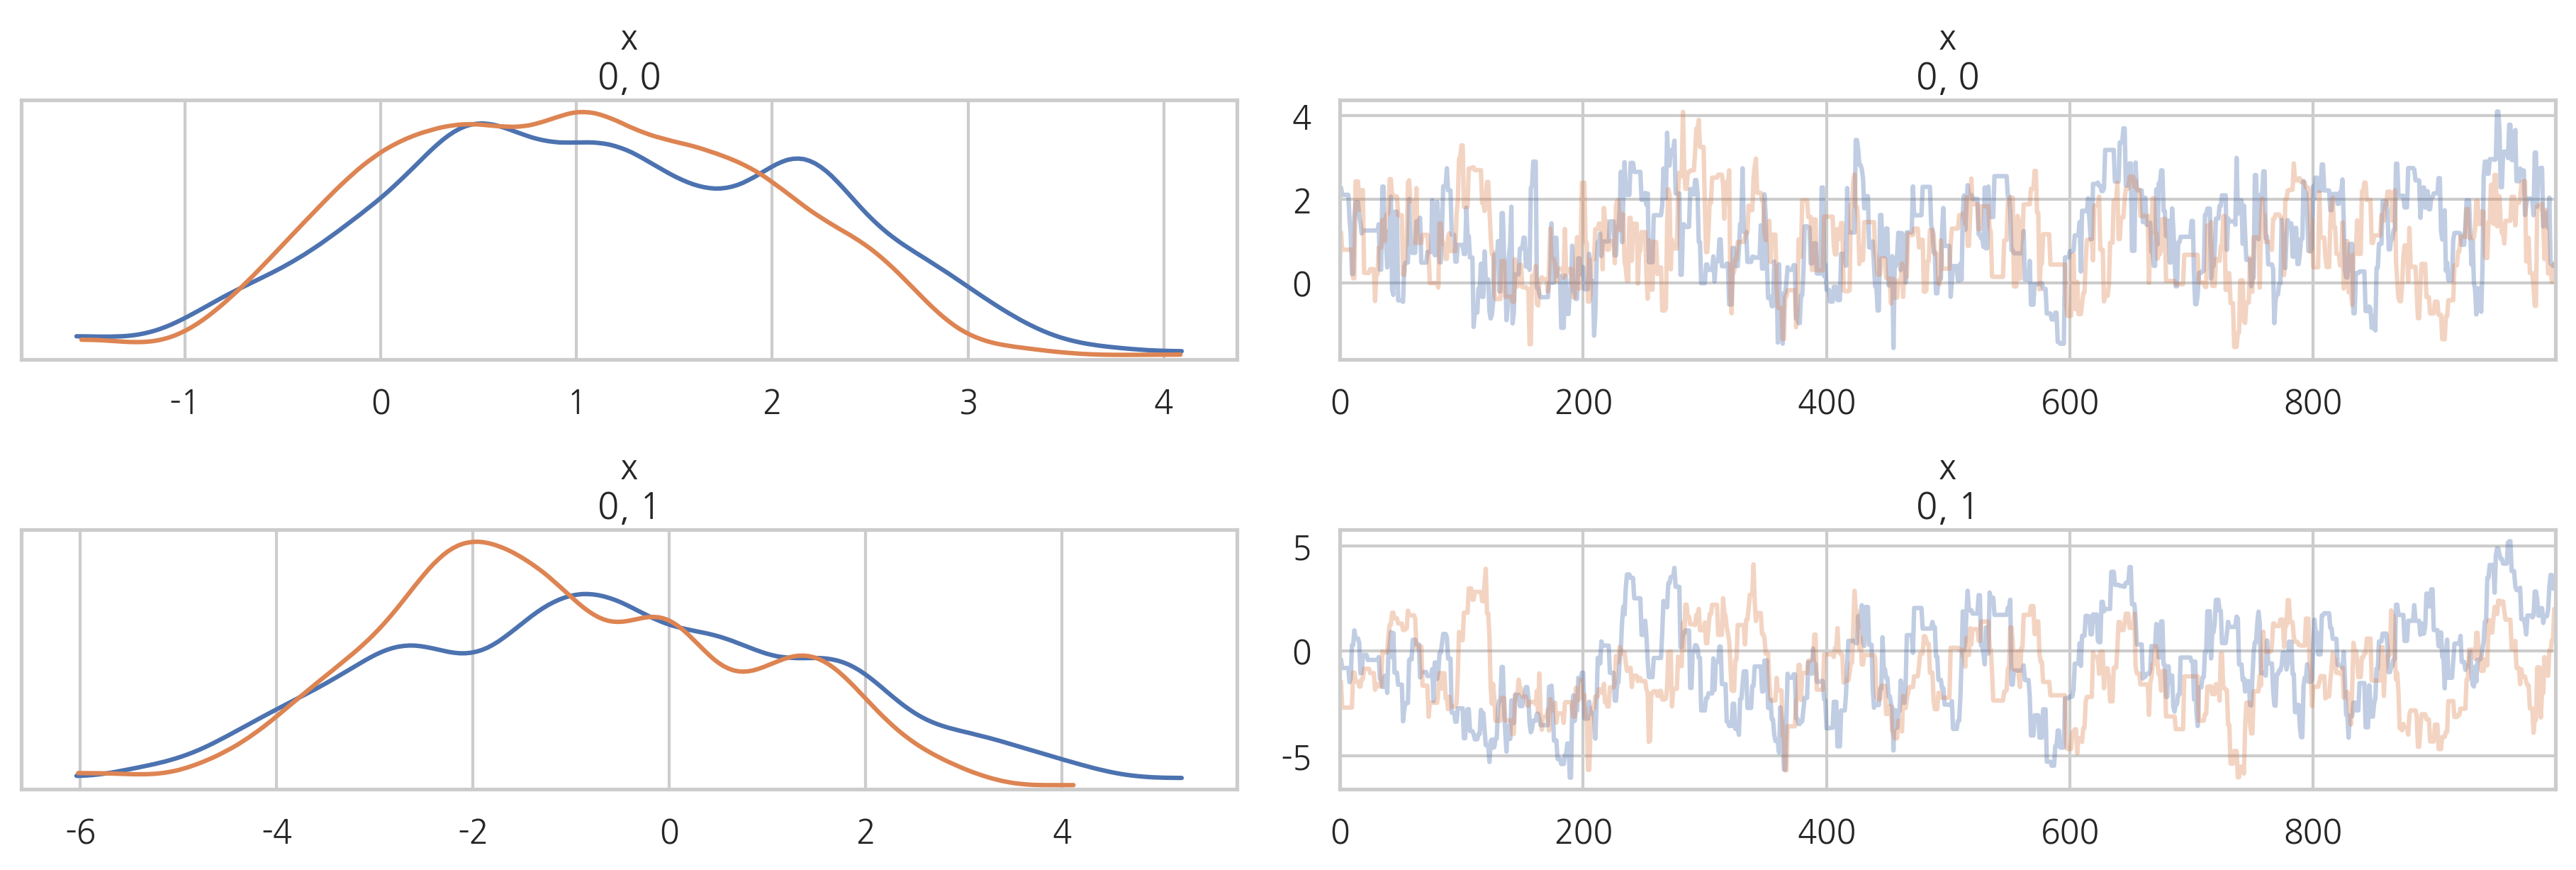

In [7]:
cov = np.array([[1., 1.5], [1.5, 4]])
mu = np.array([1, -1])

with pm.Model() as model:
    x = pm.MvNormal('x', mu=mu, cov=cov, shape=(1, 2))
    step = pm.Metropolis()
    trace = pm.sample(1000, step)

import warnings
warnings.simplefilter("ignore")

pm.traceplot(trace)
plt.show()

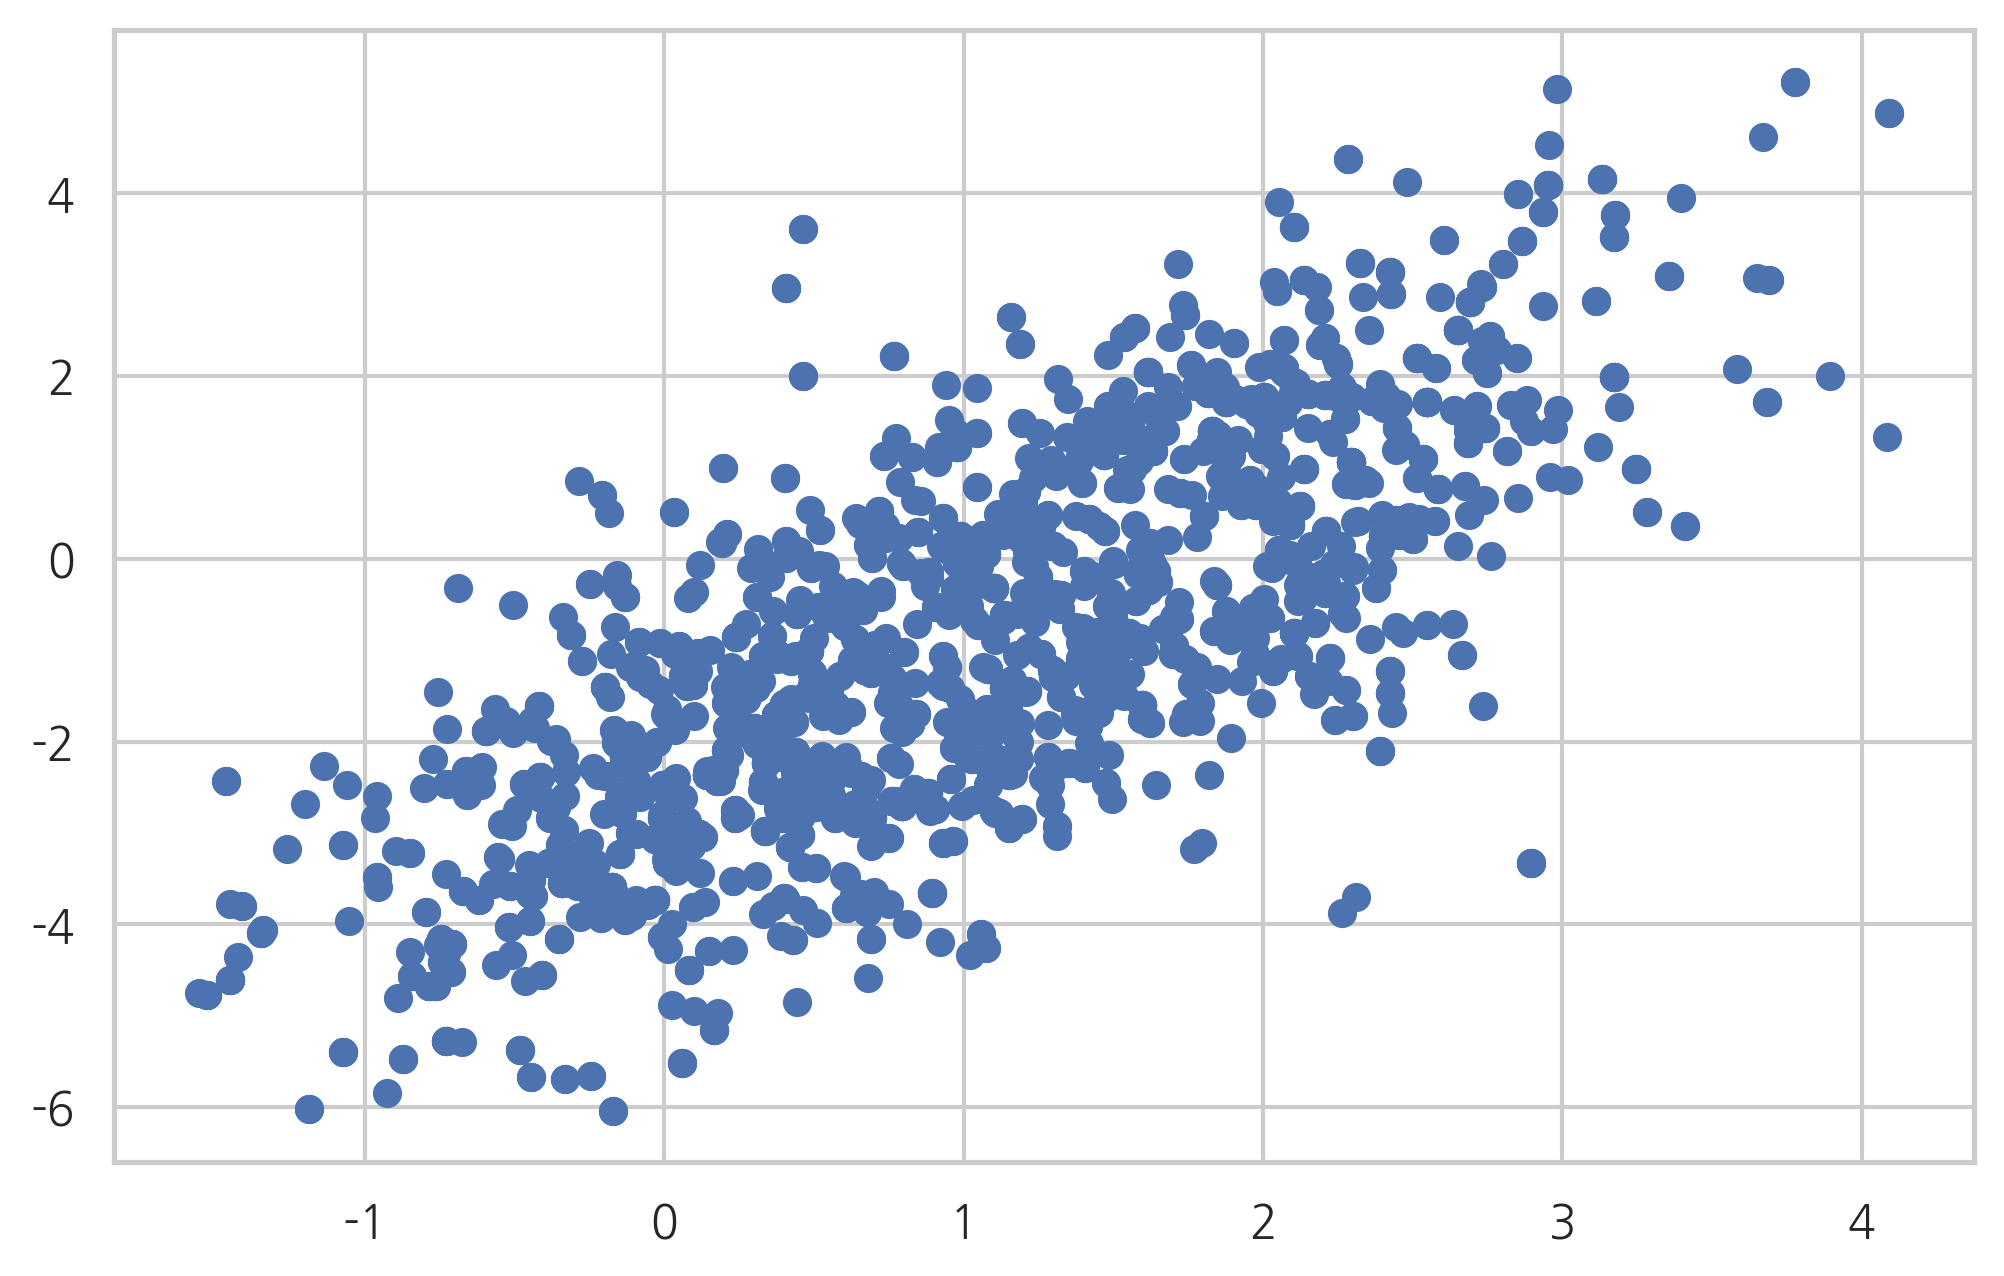

In [8]:
plt.scatter(trace['x'][:, 0, 0], trace['x'][:, 0, 1])
plt.show()

## Bayesian Estimation using MCMC

$$ P(\theta \mid x_{1},\ldots,x_{N}) \propto P(x_{1},\ldots,x_{N} \mid \theta)  P(\theta) $$


* $ P(\theta) $: Beta
* $ P(x_{1},\ldots,x_{N} \mid \theta) $: Binomial

In [9]:
theta0 = 0.7
np.random.seed(0)
x_data1 = sp.stats.bernoulli(theta0).rvs(10)
x_data1

array([1, 0, 1, 1, 1, 1, 1, 0, 0, 1])

In [10]:
with pm.Model() as model:
    theta = pm.Beta('theta', alpha=1, beta=1)
    x = pm.Bernoulli('x', p=theta, observed=x_data1)
    start = pm.find_MAP()
    step = pm.NUTS()
    trace1 = pm.sample(2000, step=step, start=start)

logp = -6.9315, ||grad|| = 2: 100%|██████████| 6/6 [00:00<00:00, 785.01it/s]
Sequential sampling (2 chains in 1 job)
NUTS: [theta]
100%|██████████| 2500/2500 [00:01<00:00, 1552.11it/s]


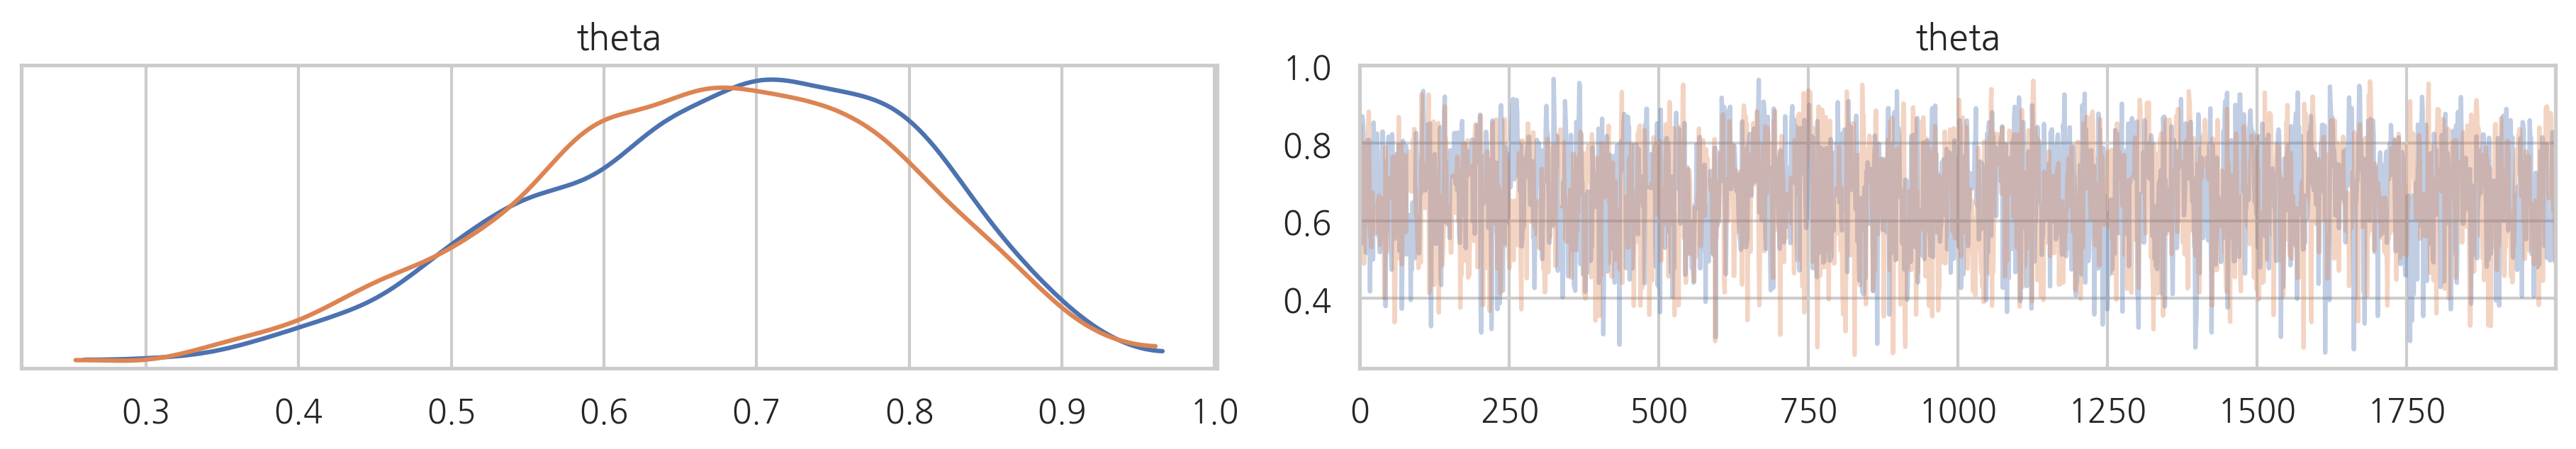

In [11]:
pm.traceplot(trace1)
plt.show()

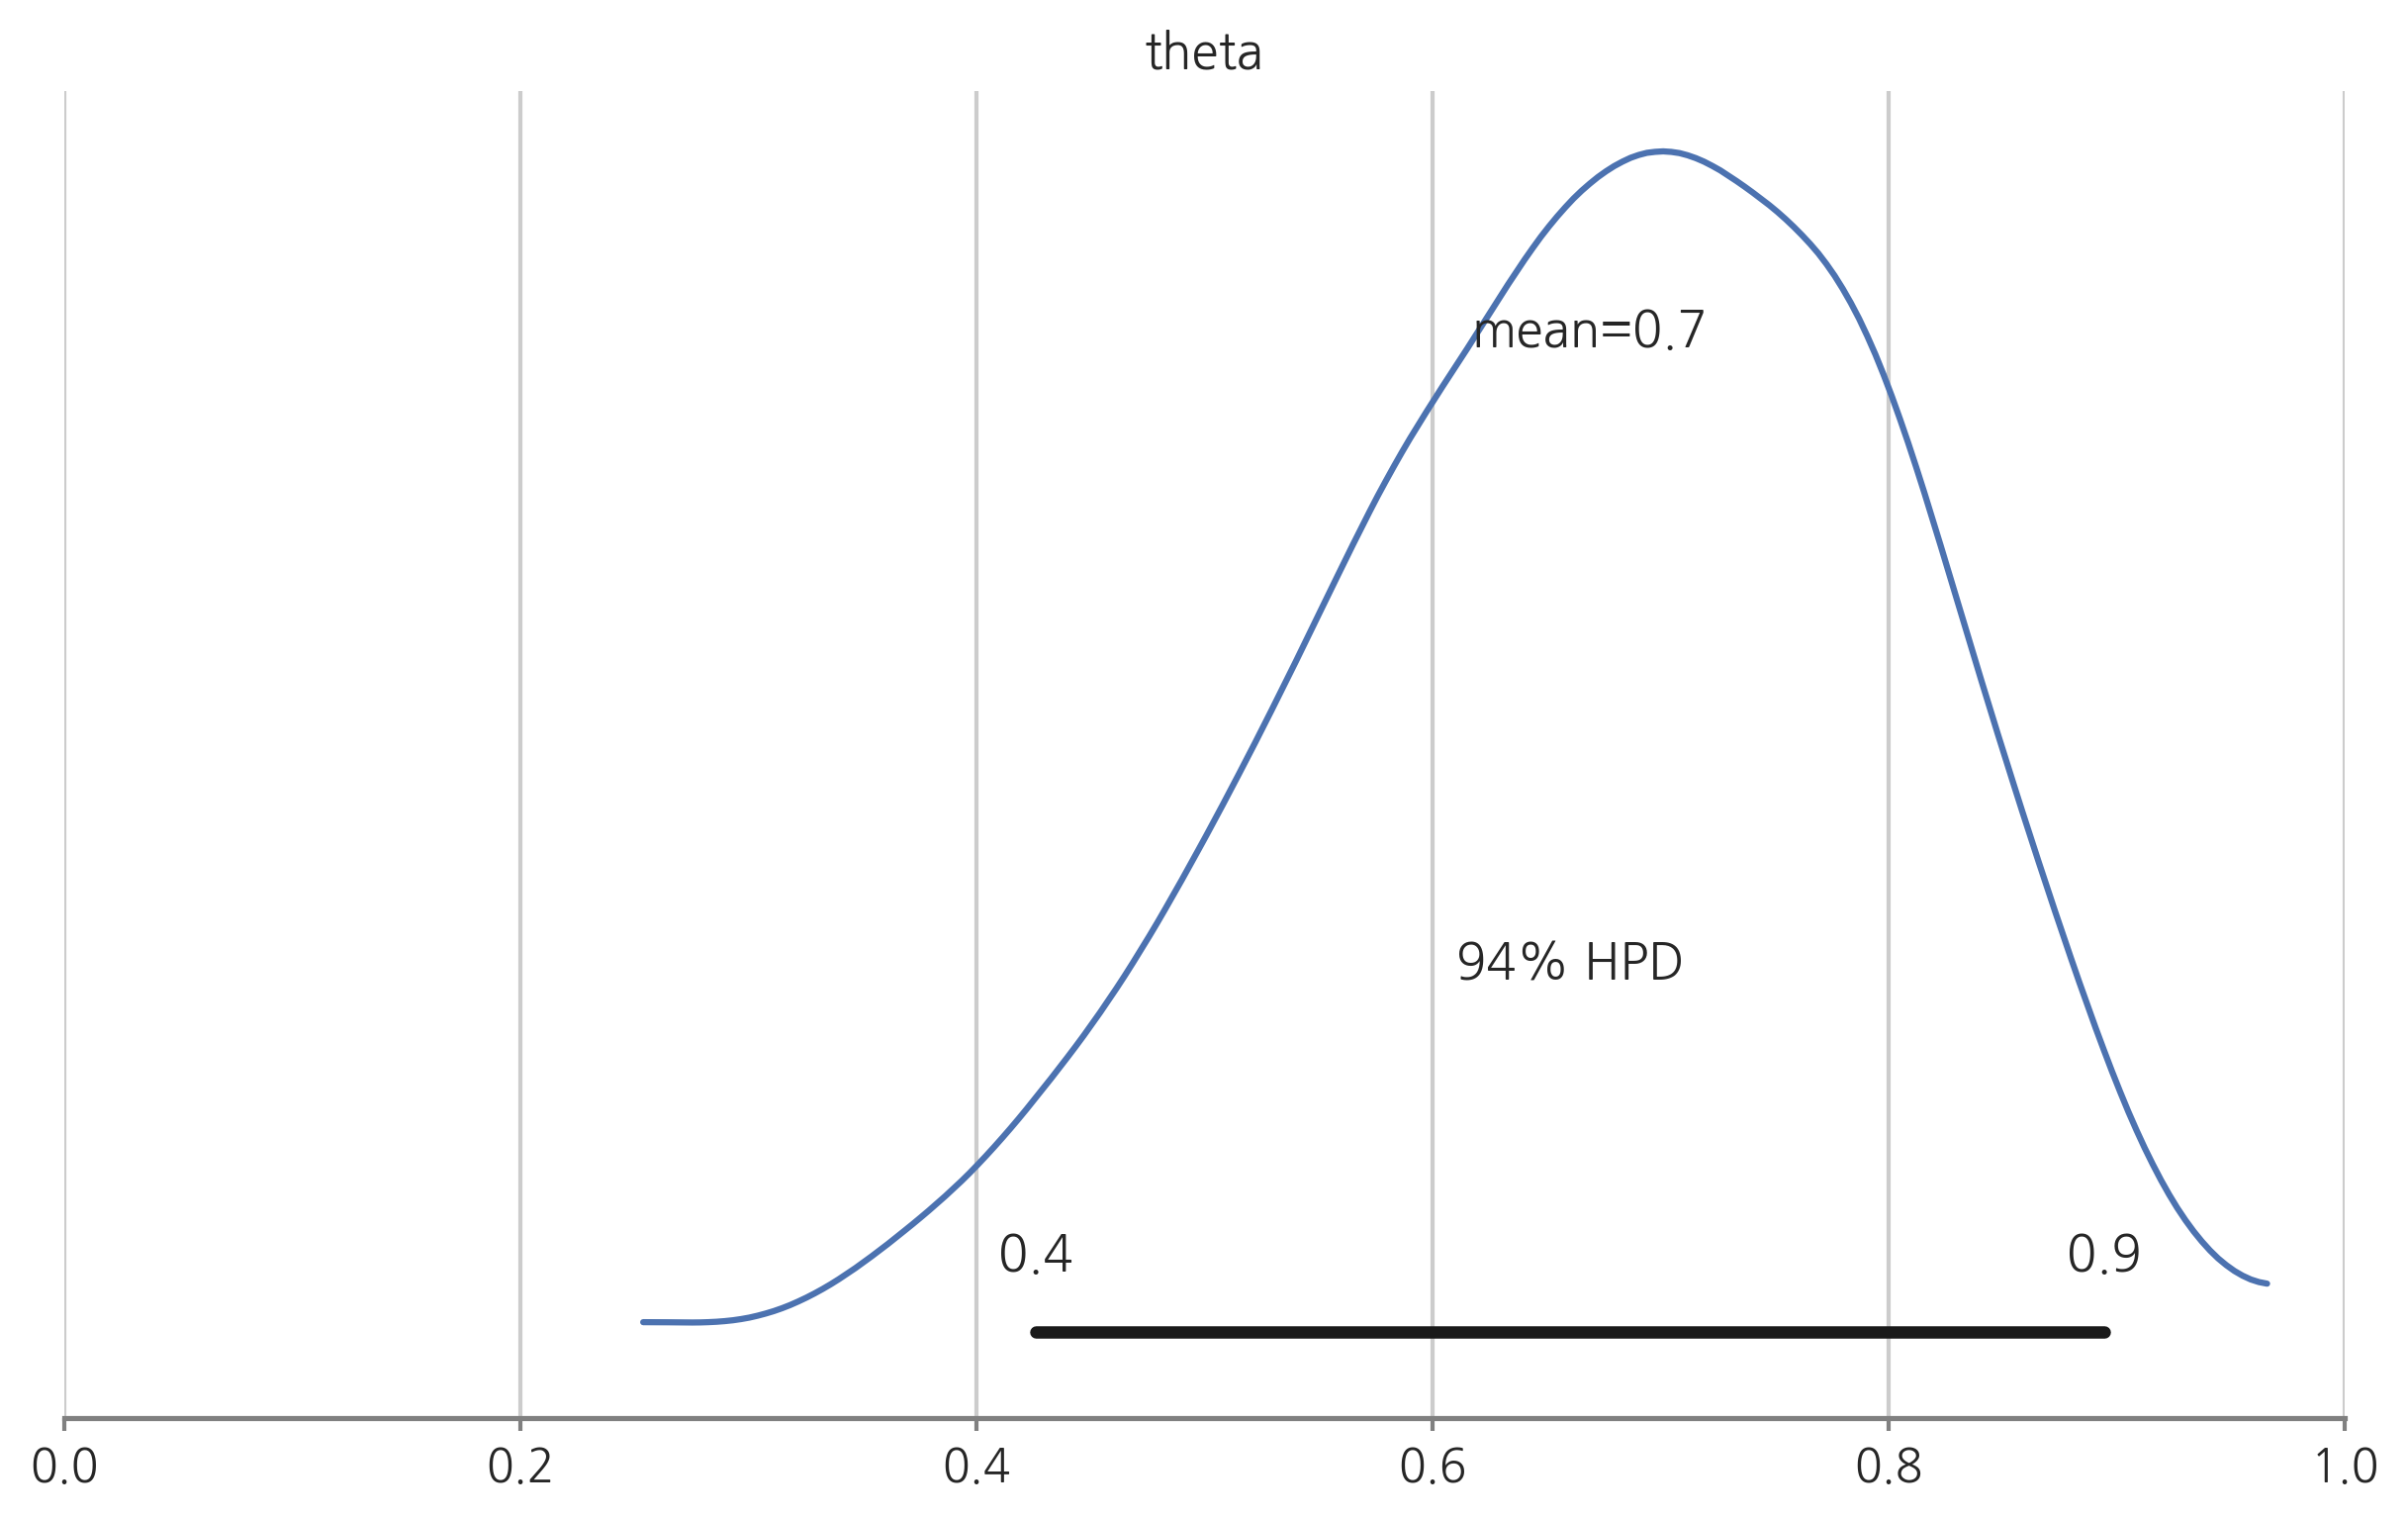

In [12]:
pm.plot_posterior(trace1)
plt.xlim(0, 1)
plt.show()

In [13]:
pm.summary(trace1)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
theta,0.668739,0.12876,0.002694,0.414753,0.898918,1872.065092,1.002132


In [14]:
np.random.seed(0)
x_data2 = sp.stats.bernoulli(theta0).rvs(500)

In [15]:
with pm.Model() as model:
    theta = pm.Beta('theta', alpha=1, beta=1)
    x = pm.Bernoulli('x', p=theta, observed=x_data2)
    start = pm.find_MAP()
    step = pm.NUTS()
    trace2 = pm.sample(1000, step=step, start=start)

logp = -346.57, ||grad|| = 110: 100%|██████████| 6/6 [00:00<00:00, 1534.13it/s]
Sequential sampling (2 chains in 1 job)
NUTS: [theta]
100%|██████████| 1500/1500 [00:00<00:00, 1715.53it/s]


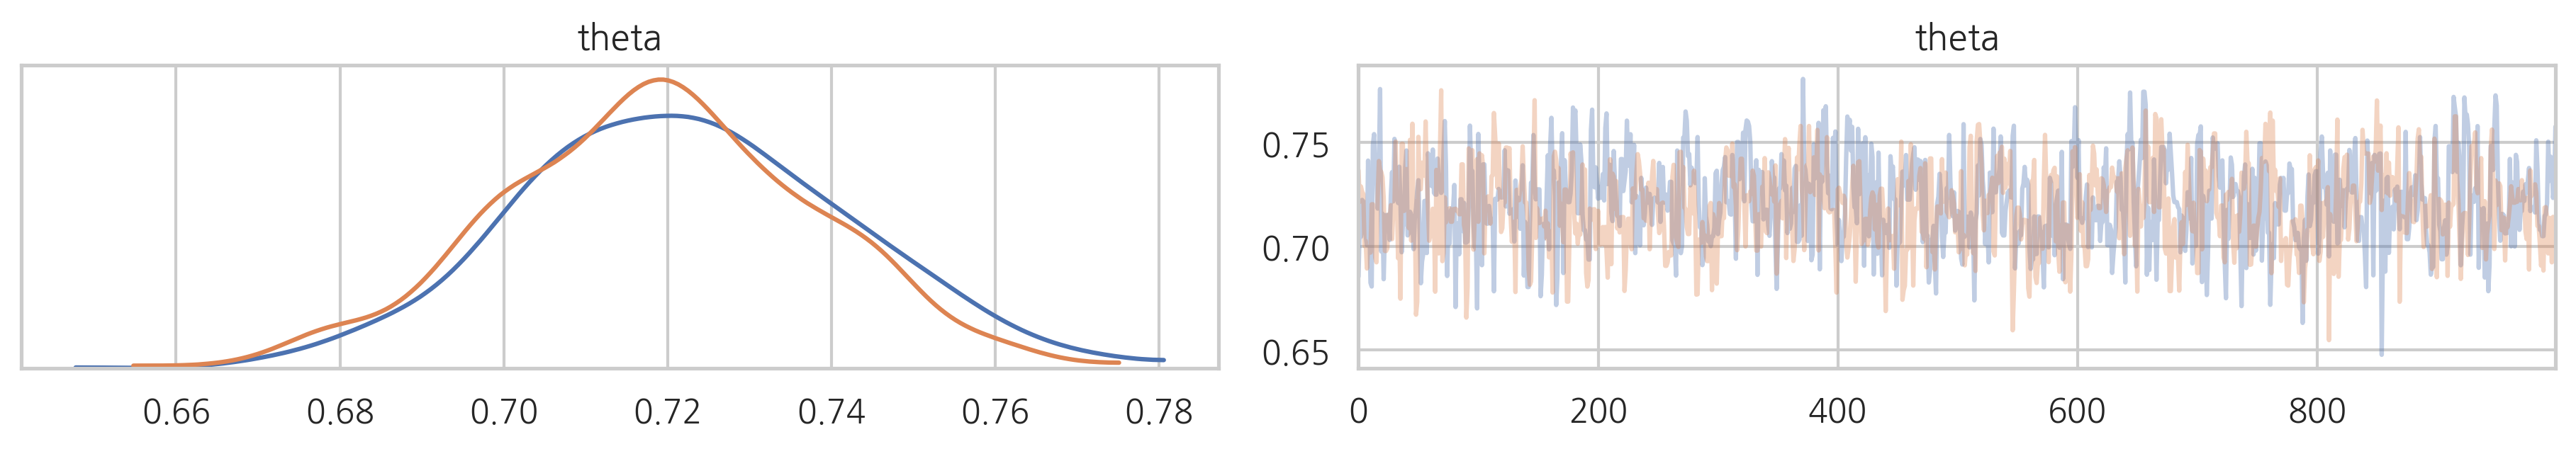

In [16]:
pm.traceplot(trace2)
plt.show()

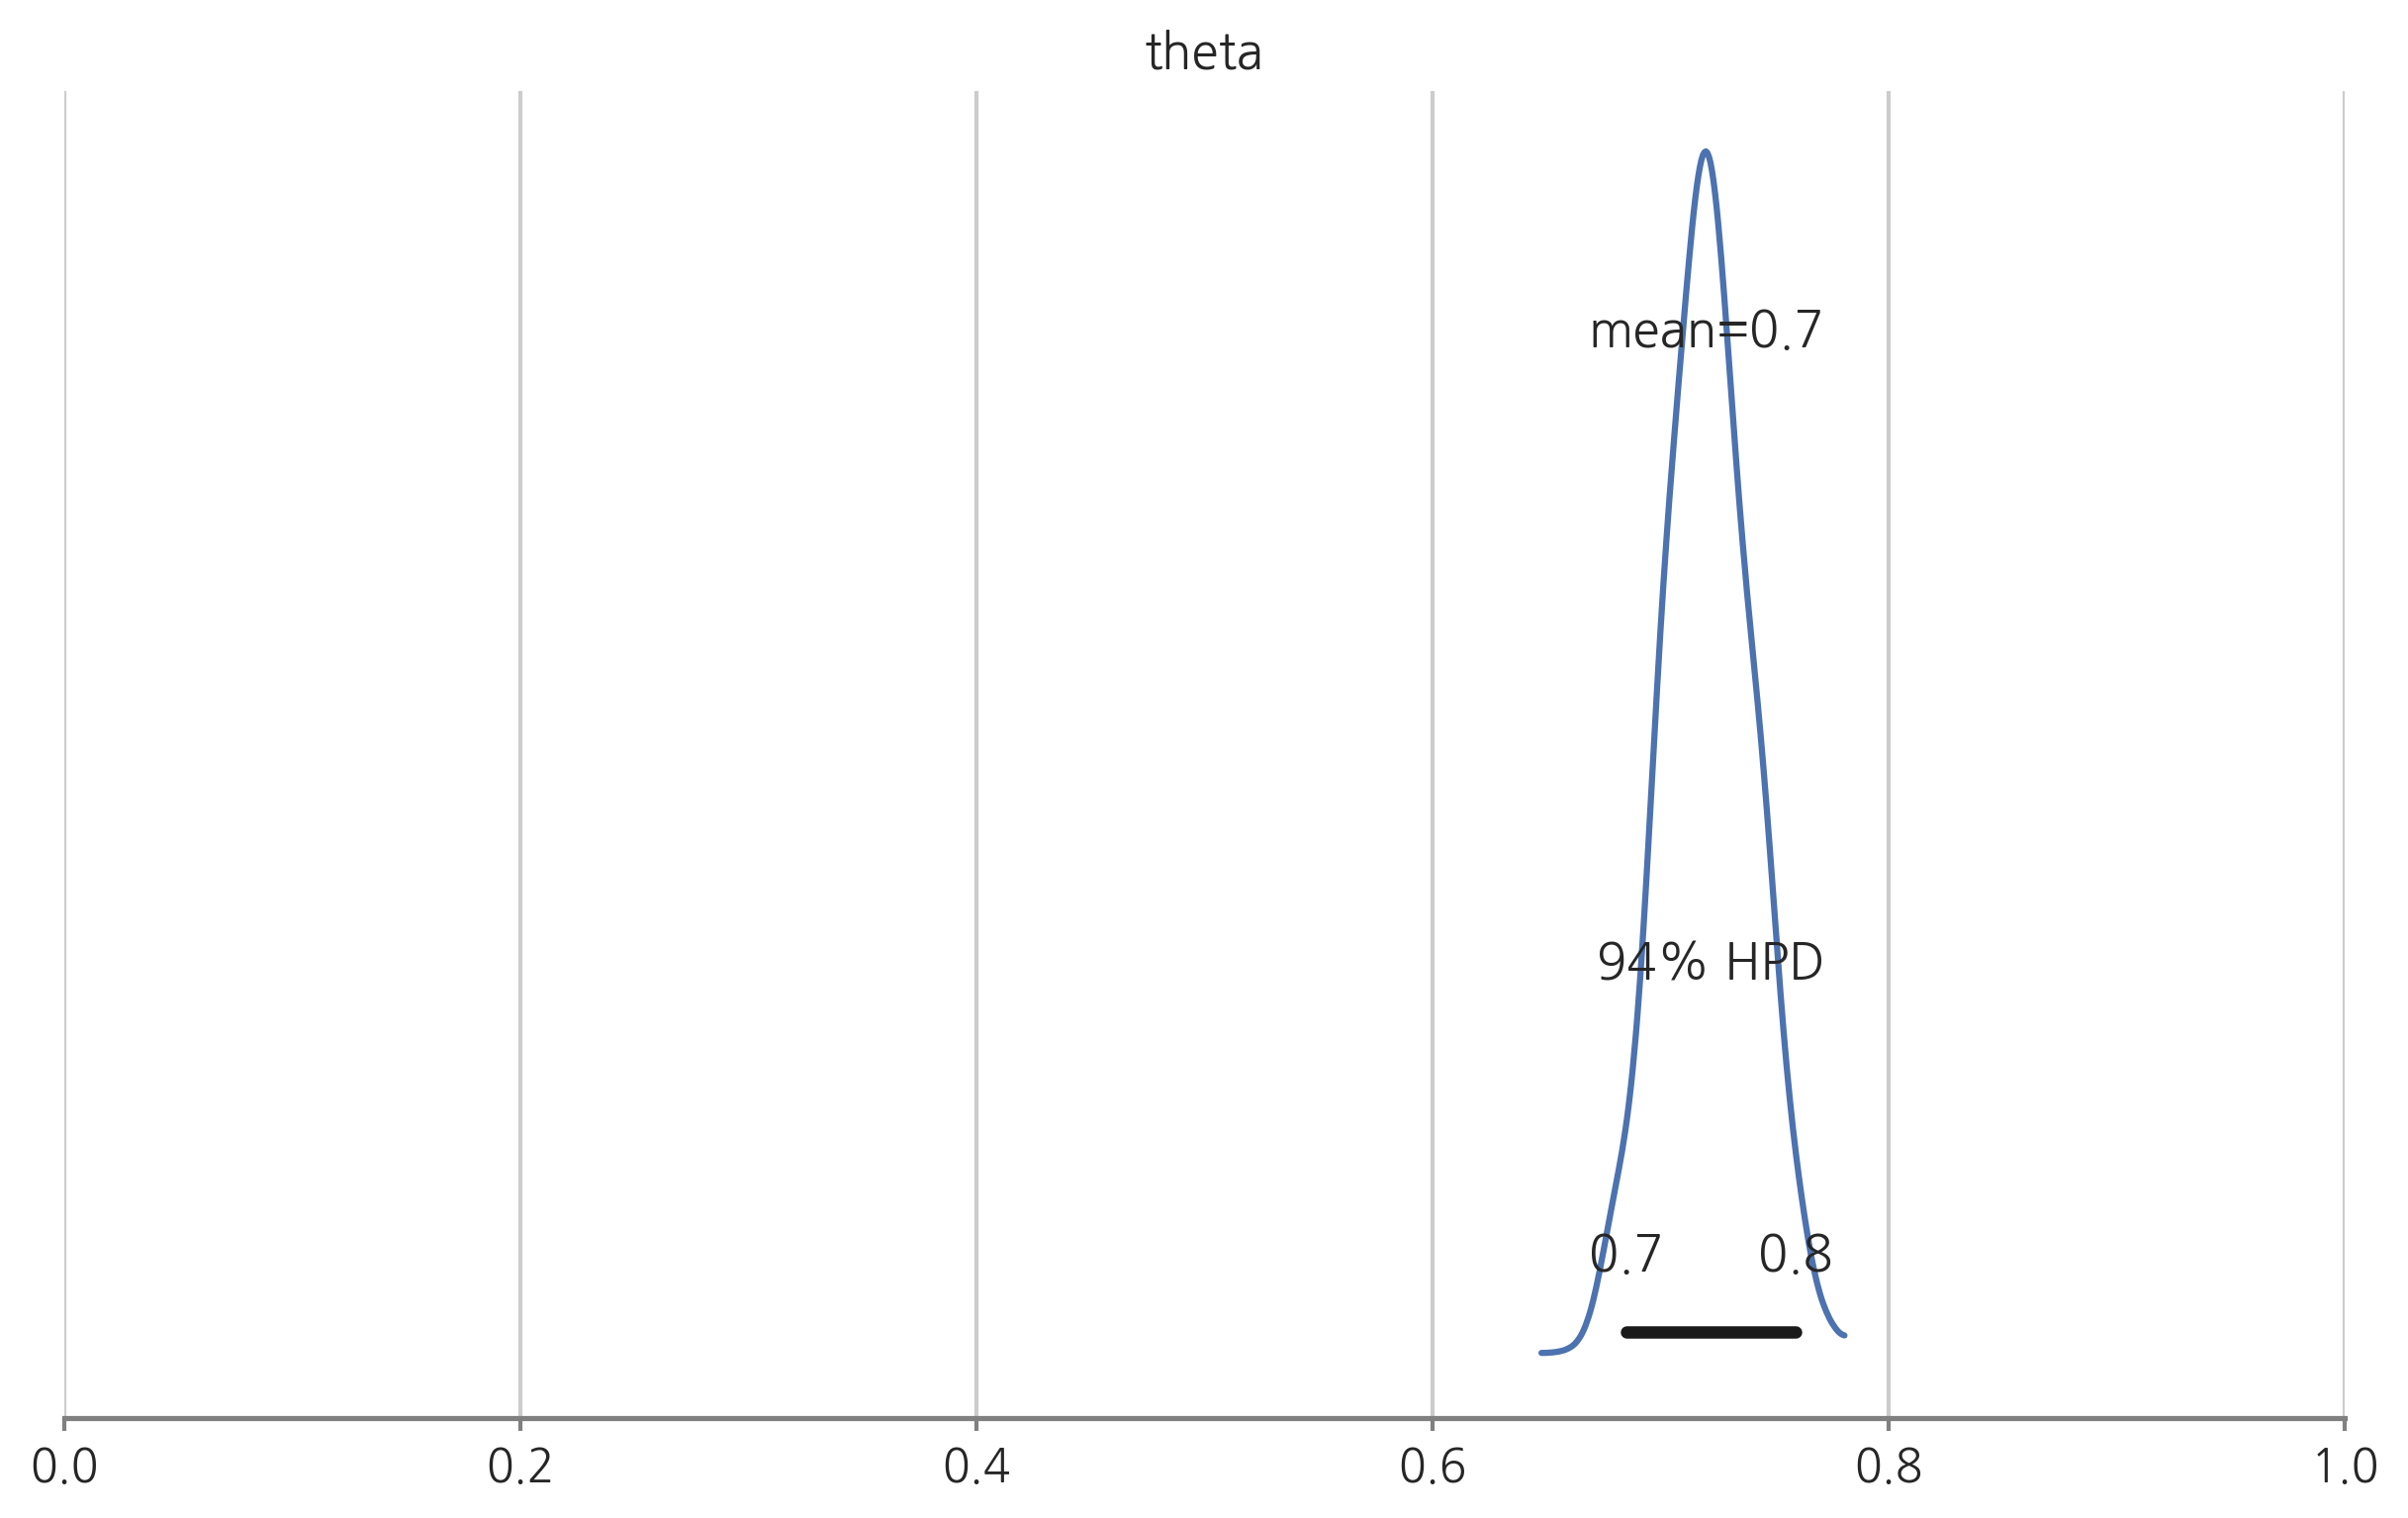

In [17]:
pm.plot_posterior(trace2)
plt.xlim(0, 1)
plt.show()

In [18]:
pm.summary(trace2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
theta,0.720217,0.019634,0.00068,0.684897,0.762561,650.687866,1.006064


## Bayesian Linear Regression using MCMC

In [19]:
from sklearn.datasets import make_regression

x, y_data, coef = make_regression(
    n_samples=100, n_features=1, bias=0, noise=20, coef=True, random_state=1)
x = x.flatten()
coef

array(80.71051956)

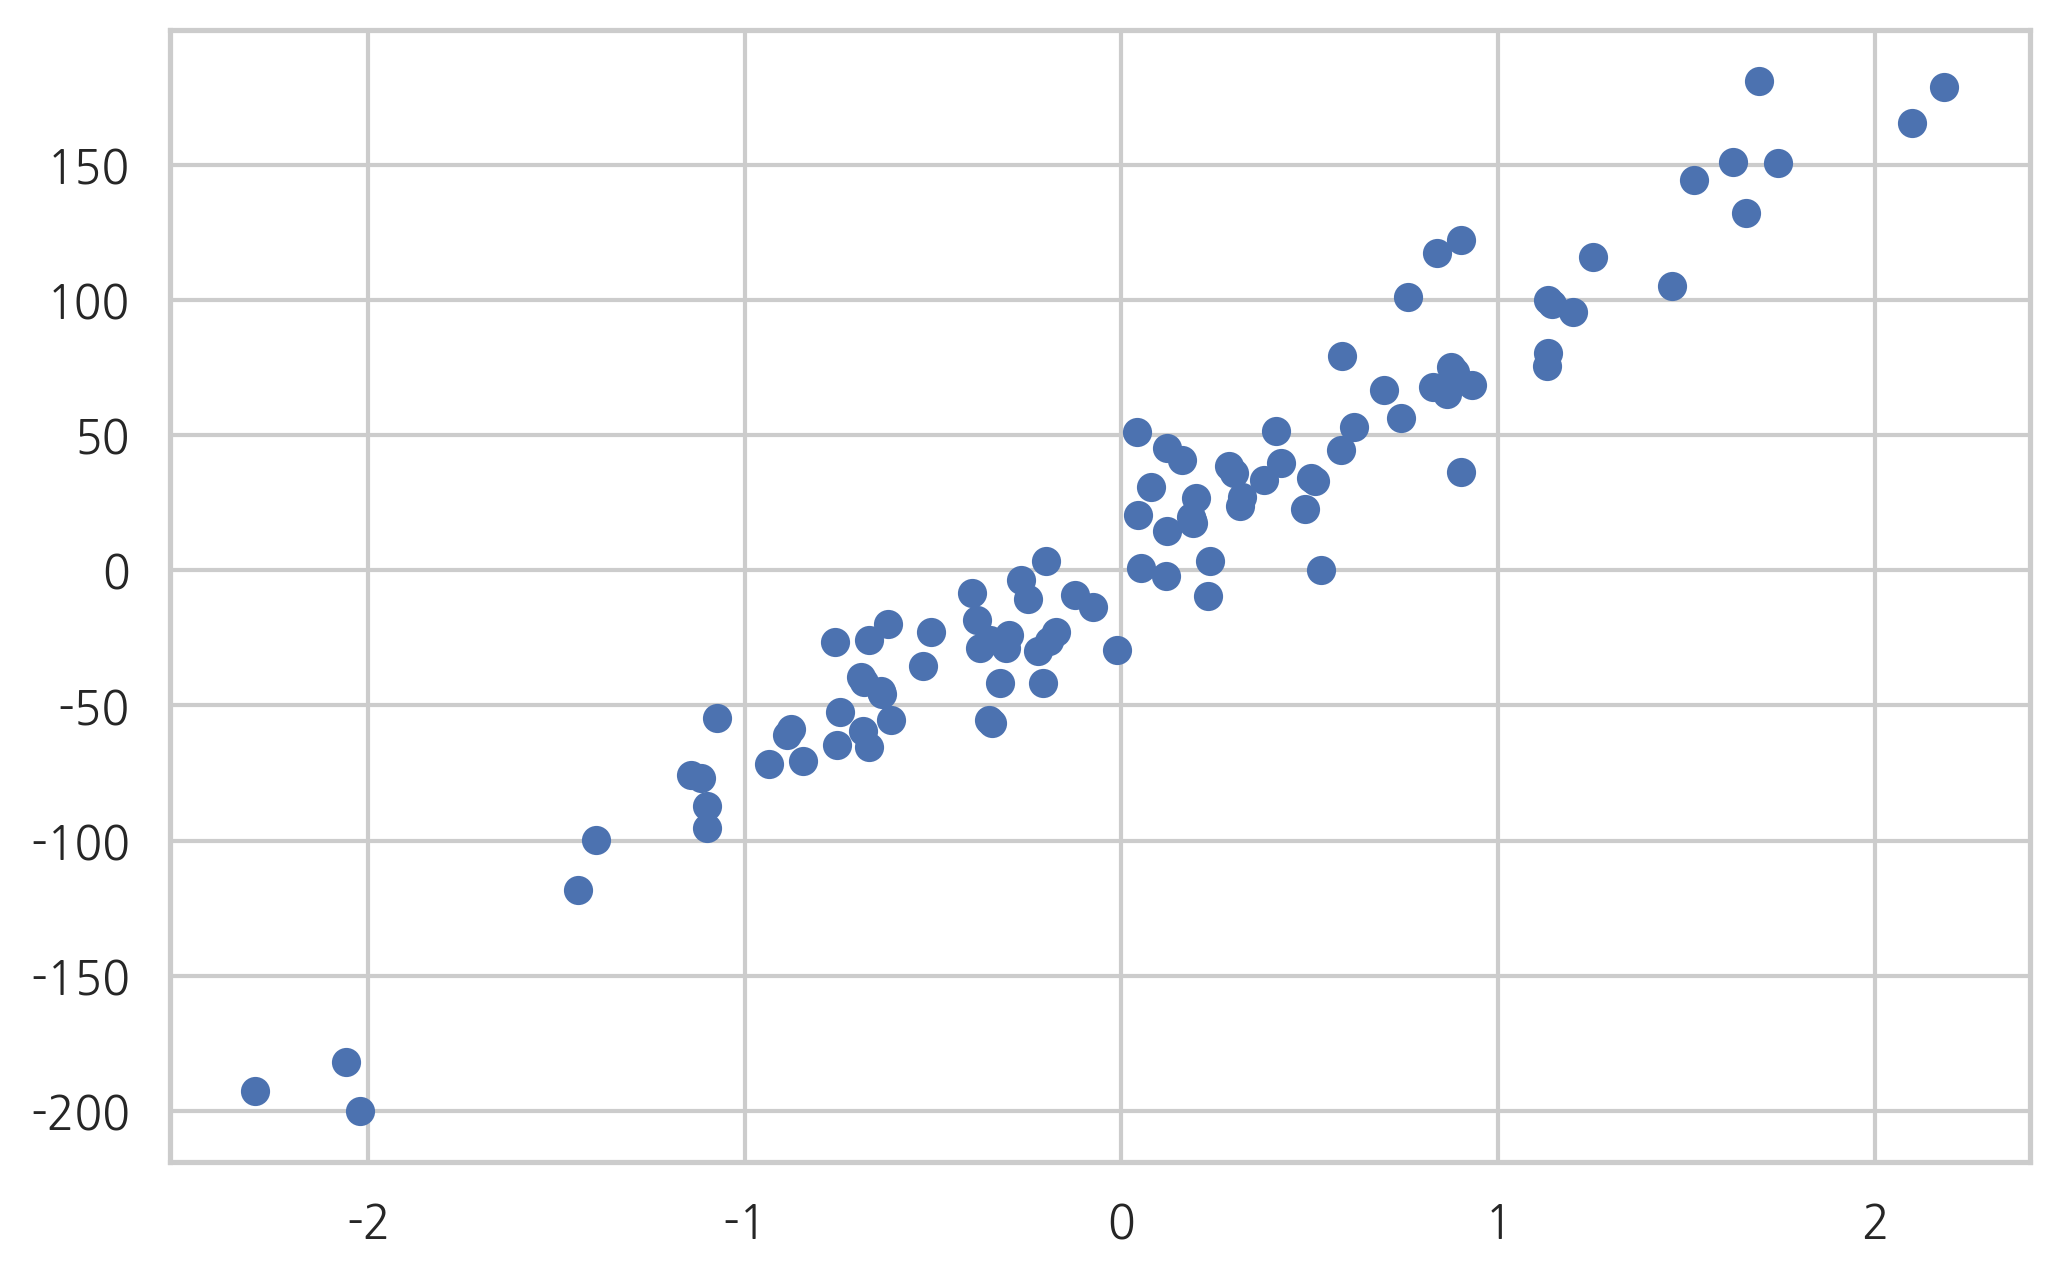

In [20]:
plt.scatter(x, y_data)
plt.show()

In [21]:
with pm.Model() as m:
    w = pm.Normal('w', mu=0, sd=50)
    b = pm.Normal('b', mu=0, sd=50)
    esd = pm.HalfCauchy('esd', 5)
    y = pm.Normal('y', mu=w * x + b, sd=esd, observed=y_data)

    start = pm.find_MAP()
    step = pm.NUTS()
    trace1 = pm.sample(10000, step=step, start=start)

logp = -448.82, ||grad|| = 6.8486: 100%|██████████| 37/37 [00:00<00:00, 2239.00it/s]  
Sequential sampling (2 chains in 1 job)
NUTS: [esd, b, w]
100%|██████████| 10500/10500 [00:07<00:00, 1409.87it/s]


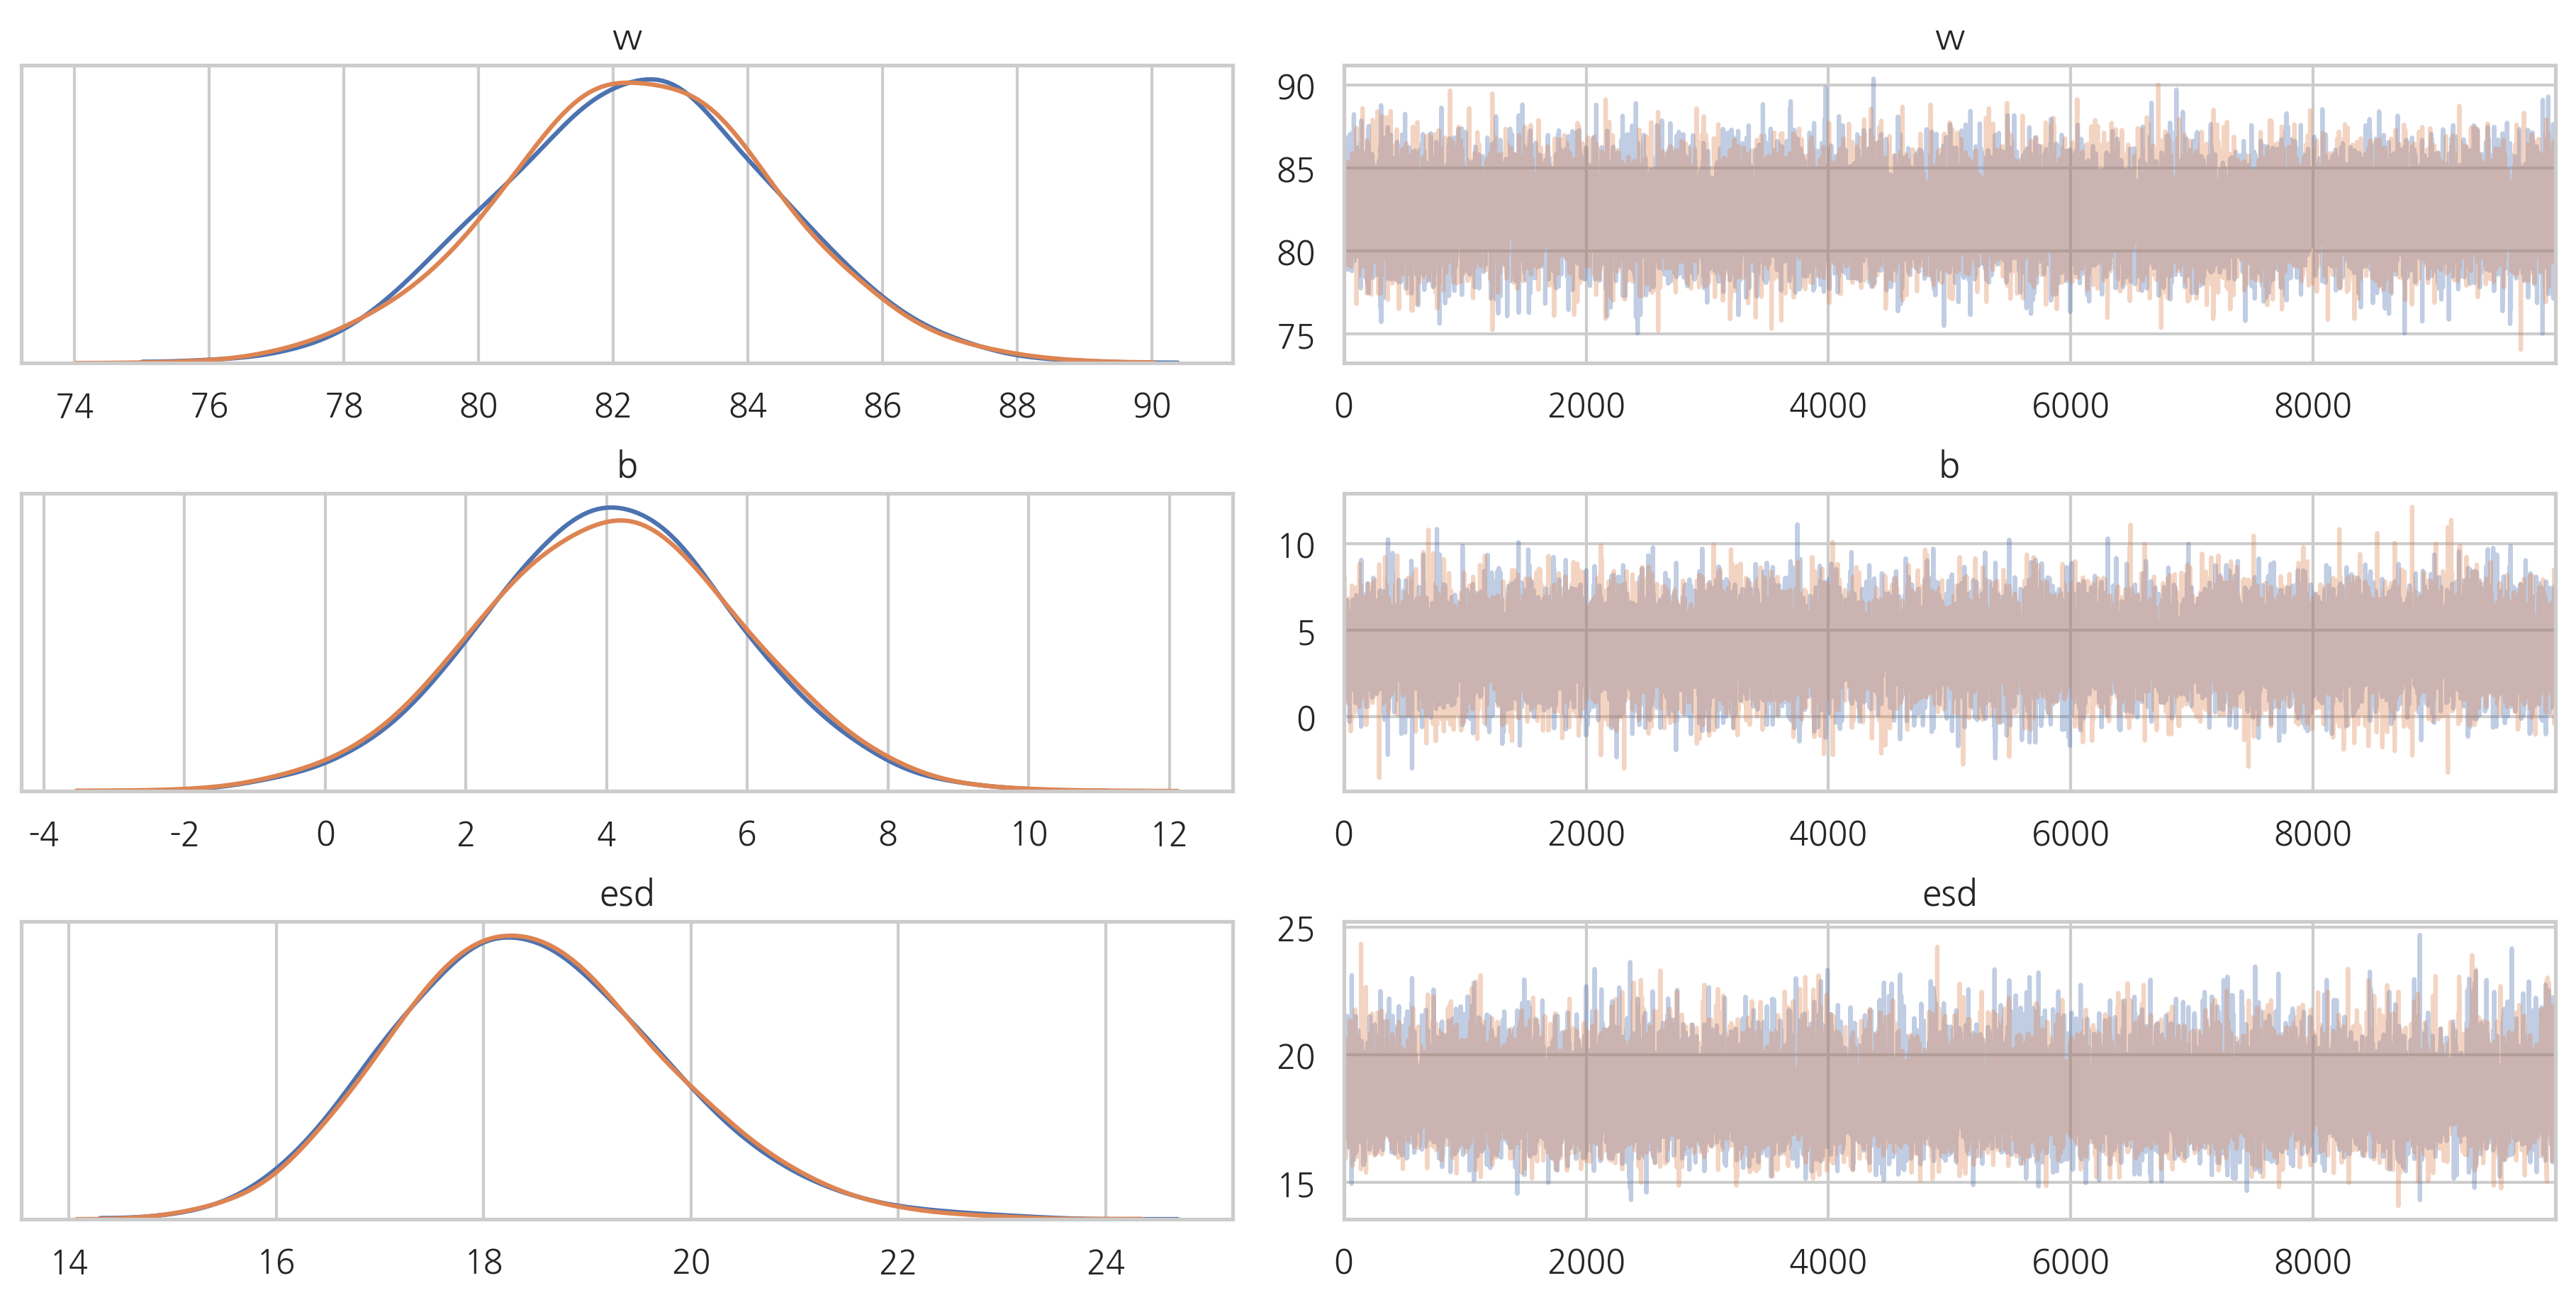

In [22]:
pm.traceplot(trace1)
plt.show()

In [23]:
pm.summary(trace1)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
w,82.367117,2.062426,0.012837,78.236705,86.311053,27313.152412,0.999952
b,4.051151,1.853362,0.009939,0.391494,7.670280,30852.396058,0.999951
esd,18.473944,1.311945,0.007736,16.079874,21.168755,28187.363922,0.999961
